<a href="https://colab.research.google.com/github/stephenchen0814/04-LinearReg_Salary/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_blobs, make_moons, make_circles, make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

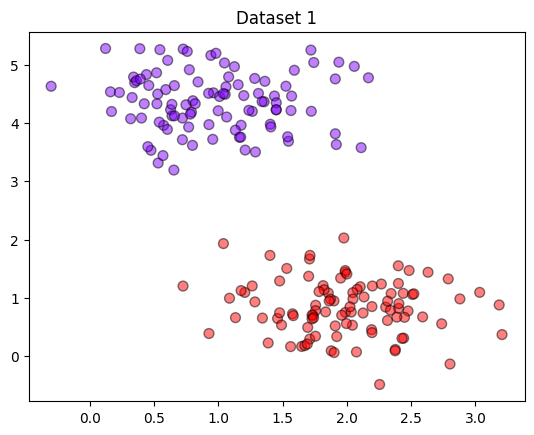

In [2]:
X1, y1 = make_blobs(n_samples=200, centers=2,random_state=0, cluster_std=0.50)   # use std=0.9 for overlap example

plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='rainbow', edgecolor='k',alpha=.5)
plt.title("Dataset 1")
plt.show()

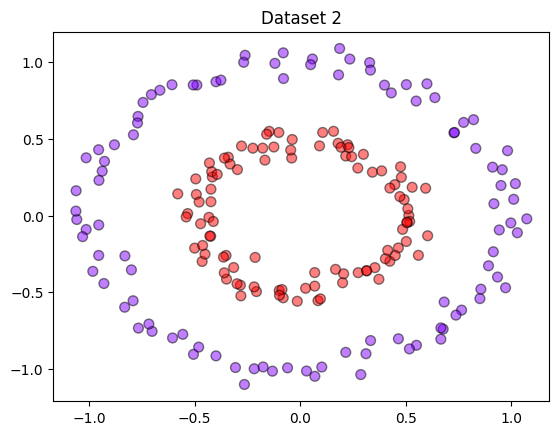

In [3]:
X2, y2  = make_circles(n_samples=200, factor=.5, noise=.05)
#
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='rainbow', edgecolor='k',alpha=.5)
plt.title("Dataset 2")
plt.show()

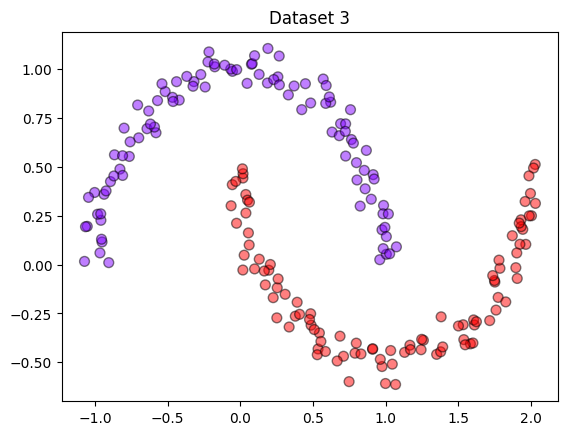

In [4]:
X3, y3 = make_moons(n_samples=200, noise=.05)
#
plt.scatter(X3[:, 0], X3[:, 1], c=y3, s=50, cmap='rainbow', edgecolor='k',alpha=.5)
plt.title("Dataset 3")
plt.show()

In [5]:
def plot_svm(X, y, w, b, title ='Plot for linear SVM'):

    def get_hyperplane(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure(figsize=(8,8))
    plt.scatter(X[:,0], X[:,1], marker='o',cmap='rainbow', s=50, edgecolor='k',c=y, alpha=0.7)

    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])

    x1_1 = get_hyperplane(x0_1, w, b, 0)
    x1_2 = get_hyperplane(x0_2, w, b, 0)

    x1_1_m = get_hyperplane(x0_1, w, b, -1)
    x1_2_m = get_hyperplane(x0_2, w, b, -1)

    x1_1_p = get_hyperplane(x0_1, w, b, 1)
    x1_2_p = get_hyperplane(x0_2, w, b, 1)

    plt.plot([x0_1, x0_2],[x1_1, x1_2], 'k--')
    plt.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'y')
    plt.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'y')

    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    plt.ylim([x1_min-0.5,x1_max+0.5])

    plt.title(title)
    plt.show()

In [6]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_epoch=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_epoch = n_epoch
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        yc = np.where(y <= 0, -1, 1)

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_epoch):
            for idx, x_i in enumerate(X):
                condition = yc[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.lr * (
                        2 * self.lambda_param * self.weights - np.dot(x_i, yc[idx])
                    )
                    self.bias =self.bias- self.lr * yc[idx]

    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

In [7]:
lr=0.01
lambda_param=0.01
n_epoch=1000

model1=SVM(learning_rate=lr, lambda_param=lambda_param, n_epoch=n_epoch)
model1.fit(X1, y1)

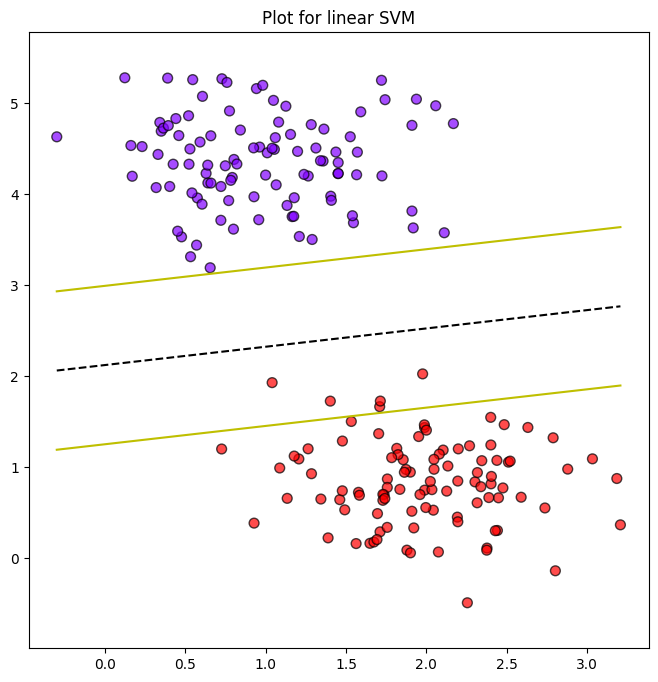

In [8]:
plot_svm(X1, y1, model1.weights, model1.bias)

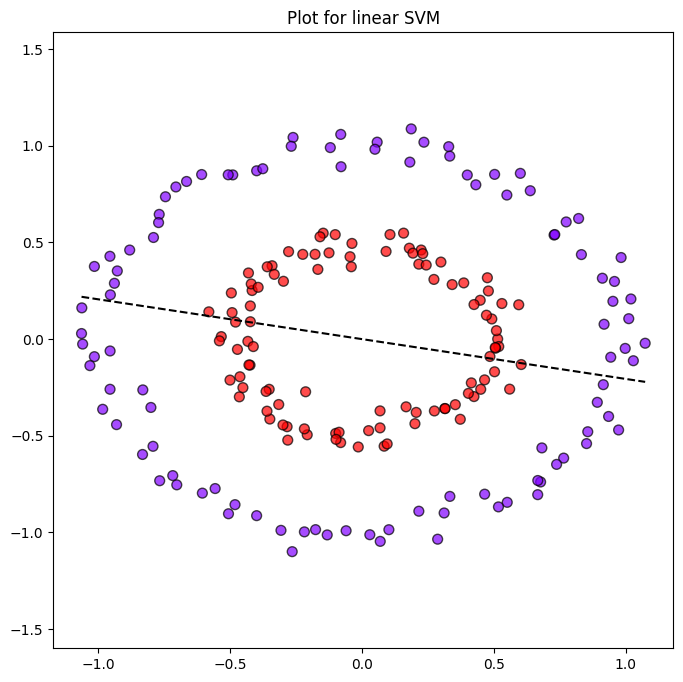

In [9]:
model2=SVM(learning_rate=lr, lambda_param=lambda_param, n_epoch=n_epoch)
model2.fit(X2, y2)
plot_svm(X2, y2, model2.weights, model2.bias)

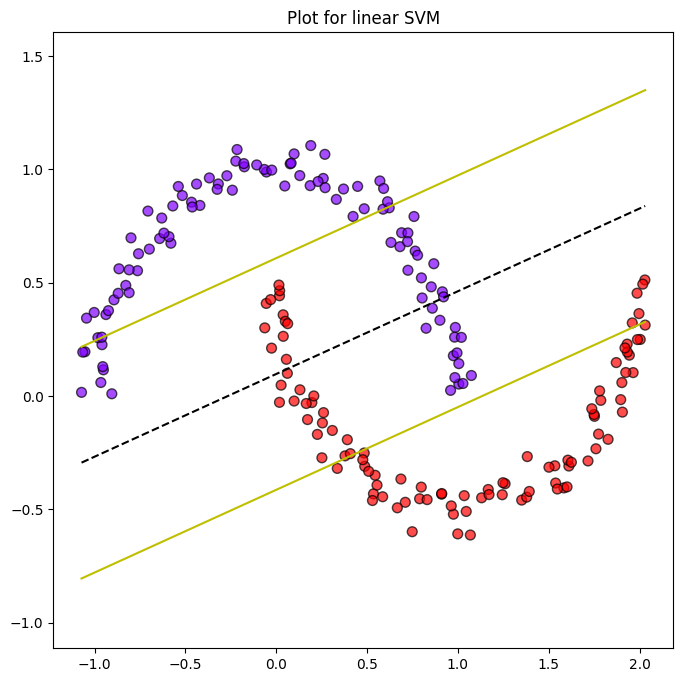

In [10]:
model3=SVM(learning_rate=lr, lambda_param=lambda_param, n_epoch=n_epoch)
model3.fit(X3, y3)
plot_svm(X3, y3, model3.weights, model3.bias)

In [11]:
class SVM_Kernel:

    def __init__(self, kernel='poly', degree=2, var=0.1, n_epoch=1000, lr= 0.001):
        self.alpha = None
        self.b = 0
        self.degree = degree
        self.C = 1
        self.var = var
        self.n_epoch = n_epoch
        self.lr = lr

        if kernel == 'poly':
            self.kernel = self.polynomial_kernel # polynomial kernel
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernel # guassian kernel

    def polynomial_kernel(self,X,Z):
        return (1 + X.dot(Z.T))**self.degree #(c + X.y)^degree

    def gaussian_kernel(self, X,Z):
        return np.exp(-(1 / self.var ) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2) #e ^-(1/ σ2) ||X-y|| ^2

    def fit(self,X,y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        self.ones = np.ones(X.shape[0])

        y_mul_kernal = np.outer(y, y) * self.kernel(X, X) # yi yj K(xi, xj)

        for i in range(self.n_epoch):
            gradient = self.ones - y_mul_kernal.dot(self.alpha) # 1 – yi ∑ αj yj K(xj, xi)

            self.alpha += self.lr * gradient # α = α + lr*(gradient) to maximize
            self.alpha[self.alpha > self.C] = self.C # 0<α<C
            self.alpha[self.alpha < 0] = 0 # 0<α<C

            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_mul_kernal) # ∑αi – (1/2) ∑i ∑j αi αj yi yj K(xi, xj)

        alpha_index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]

        # for bias b, we will only consider α which are 0<α<C
        b_list = []
        for index in alpha_index:
            b_list.append(y[index] - (self.alpha * y).dot(self.kernel(X, X[index])))

        self.b = np.mean(b_list) # avg0<αi<C{ yi – ∑αjyj K(xj, xi) }

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)

    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b


    def plot(self, title='Plot for non linear SVM'):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap='rainbow', edgecolor='k', alpha=.7)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx = np.linspace(xlim[0], xlim[1], 50)
        yy = np.linspace(ylim[0], ylim[1], 50)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self.decision_function(xy).reshape(XX.shape)
        ax.contour(XX, YY, Z, levels=[-1, 0, 1],linestyles=['-', '--', '-'], colors=['y', 'k', 'y'])
        plt.title(title)
        plt.show()

Accuracy:  1.0


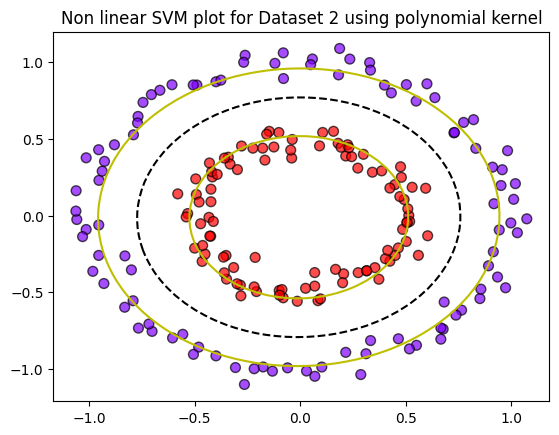

In [12]:
svm_poly = SVM_Kernel(kernel = 'poly',degree=2)
y2g = np.where(y2 <= 0, -1, 1)
svm_poly.fit(X2,y2g)
print("Accuracy: ", svm_poly.score(X2,y2g))
svm_poly.plot('Non linear SVM plot for Dataset 2 using polynomial kernel')

Accuracy:  1.0


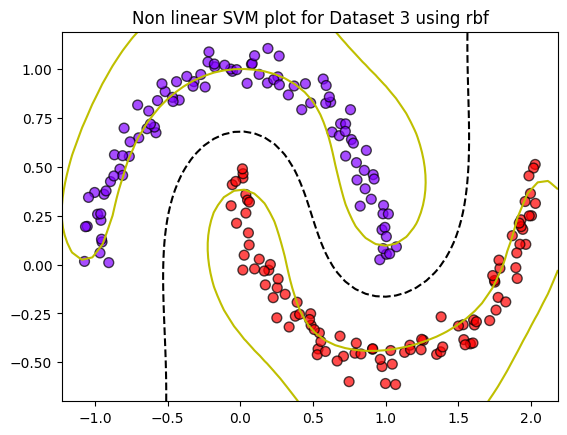

In [13]:
var=X3.var()
y3g = np.where(y3 <= 0, -1, 1)
svm_rbf = SVM_Kernel(kernel = 'rbf', var=var)
svm_rbf.fit(X3,y3g)
print("Accuracy: ", svm_rbf.score(X3,y3g))
svm_rbf.plot('Non linear SVM plot for Dataset 3 using rbf')

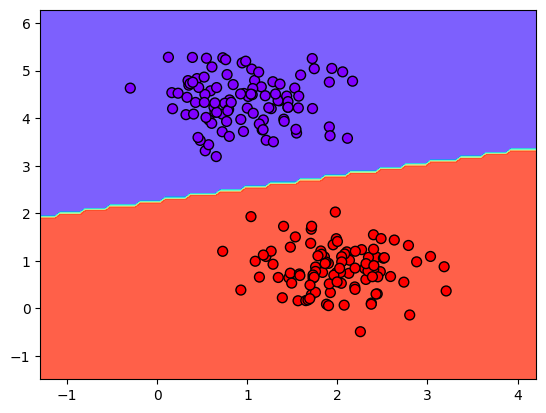

In [14]:
svm_model1=svm.SVC(kernel='linear')
svm_model1.fit(X1, y1)


DecisionBoundaryDisplay.from_estimator(
        svm_model1,
        X1,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X1[:, 0], X1[:, 1],
            c=y1,
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

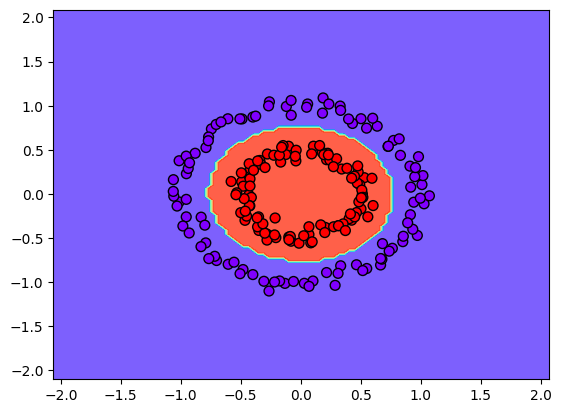

In [15]:
svm_model2=svm.SVC(kernel='poly', degree=2)
svm_model2.fit(X2, y2)

DecisionBoundaryDisplay.from_estimator(
        svm_model2,
        X2,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X2[:, 0], X2[:, 1],
            c=y2,
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

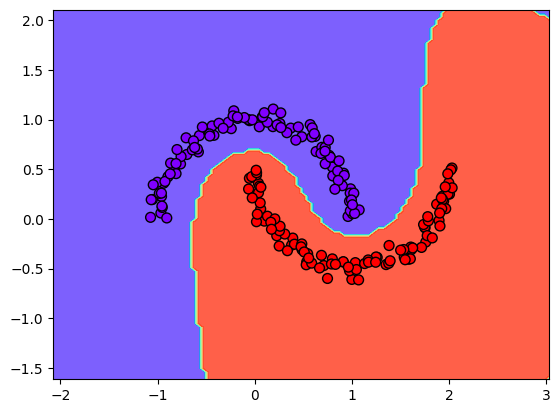

In [16]:
svm_model3=svm.SVC(kernel='rbf', C=2)
svm_model3.fit(X3, y3)

DecisionBoundaryDisplay.from_estimator(
        svm_model3,
        X3,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X3[:, 0], X3[:, 1],
            c=y3,
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

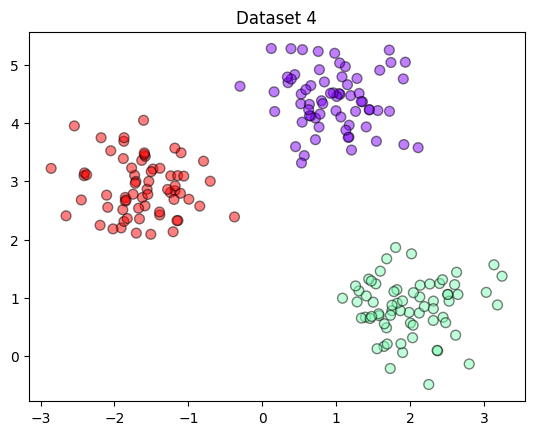

In [17]:
X4, y4 = make_blobs(n_samples=200, centers=3,random_state=0, cluster_std=0.50)   # use std=0.9 for overlap example

plt.scatter(X4[:, 0], X4[:, 1], c=y4, s=50, cmap=plt.cm.rainbow,edgecolor='black',alpha=.5)
plt.title("Dataset 4")
plt.show()

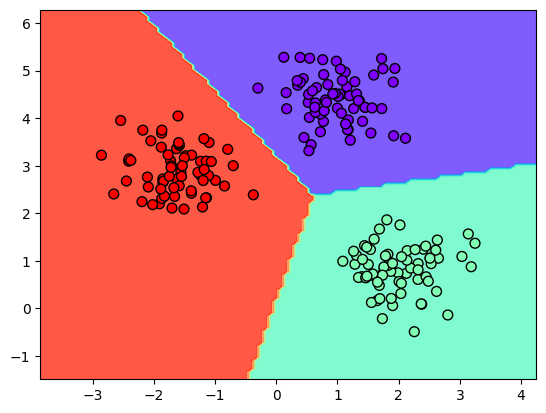

In [18]:
svm_model4=svm.LinearSVC() #by default uses OVR
svm_model4.fit(X4, y4)

DecisionBoundaryDisplay.from_estimator(
        svm_model4,
        X4,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X4[:, 0], X4[:, 1],
            c=y4,
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

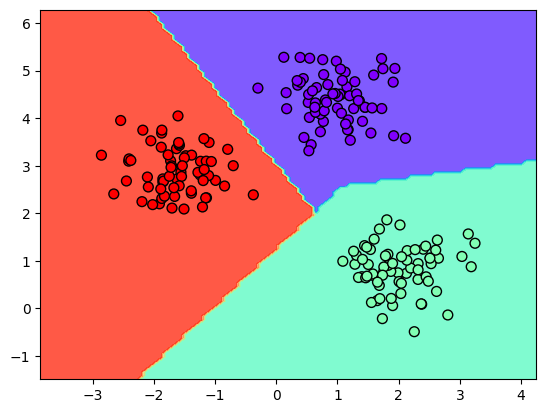

In [19]:
svm_model4=svm.SVC(kernel='linear' ) #by default uses OVO
svm_model4.fit(X4, y4)

DecisionBoundaryDisplay.from_estimator(
        svm_model4,
        X4,
        response_method="predict",
        cmap=plt.cm.rainbow,
        alpha=0.8
    )

plt.scatter(X4[:, 0], X4[:, 1],
            c=y4,
            cmap=plt.cm.rainbow,
            s=50, edgecolors="k")
plt.show()

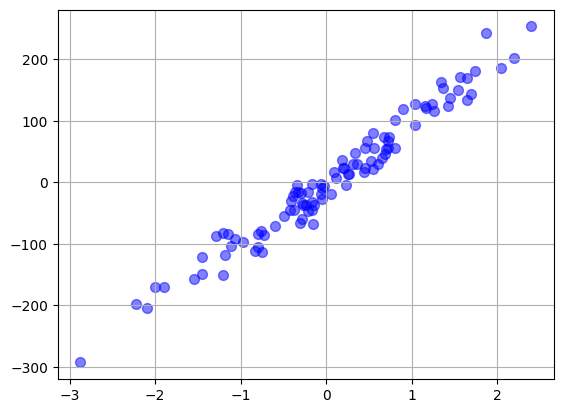

In [20]:
X1R, y1R = make_regression(n_samples=100, n_features=1, noise=20)


fig=plt.figure()
xv=np.linspace(0,5, 1000)
plt.grid()

plt.scatter(X1R,y1R, color='blue', s=50, alpha=.5)
plt.show()

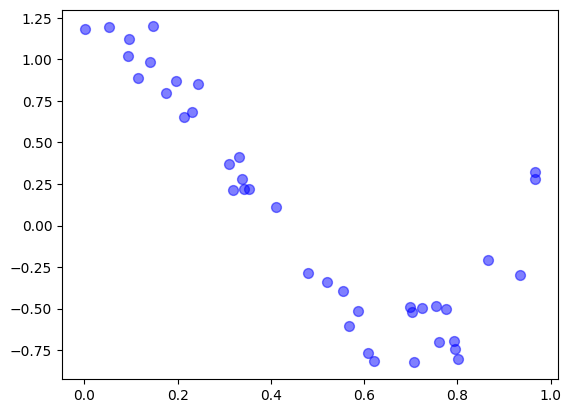

In [21]:
n_samples=40
X2R = np.random.rand(n_samples)
y2R=np.cos(1.5 * np.pi * X2R)+0.5*np.random.rand(n_samples)

X2R=X2R.reshape(-1,1)

fig=plt.figure()
plt.scatter(X2R,y2R, c='b', s=50, alpha=.5)
fig.show()

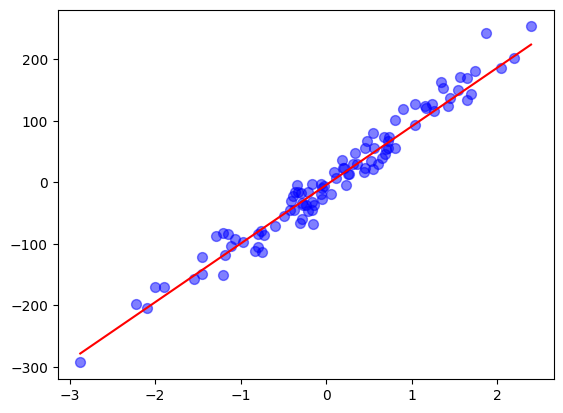

In [22]:
regressor1 = svm.SVR(kernel = 'linear', C=10)
regressor1.fit(X1R, y1R)

xv = np.arange(min(X1R), max(X1R), 0.01).reshape(-1, 1)
plt.scatter(X1R, y1R, color = 'blue',s=50, alpha=.5)
plt.plot(xv, regressor1.predict(xv), color = 'red')

plt.show()

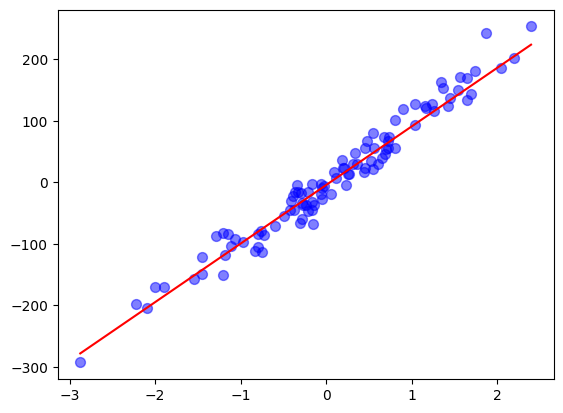

In [23]:
regressor1a = svm.LinearSVR(C=10)
regressor1a.fit(X1R, y1R)
xv = np.arange(min(X1R), max(X1R), 0.01).reshape(-1, 1)
plt.scatter(X1R, y1R, color = 'blue',s=50, alpha=.5)
plt.plot(xv, regressor1a.predict(xv), color = 'red')

plt.show()

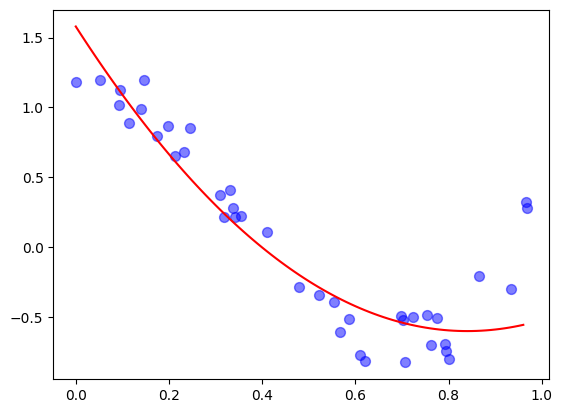

In [24]:
regressor2 = svm.SVR(kernel = 'poly', degree=2, coef0=1) # you need coef0 here. It is the little c inside (c+xy)^n kernel. Defoult value is 0

regressor2.fit(X2R, y2R)

xv = np.arange(min(X2R), max(X2R), 0.01).reshape(-1, 1)
plt.scatter(X2R, y2R, color = 'blue', s=50, alpha=.5)
plt.plot(xv, regressor2.predict(xv), color = 'red')

plt.show()

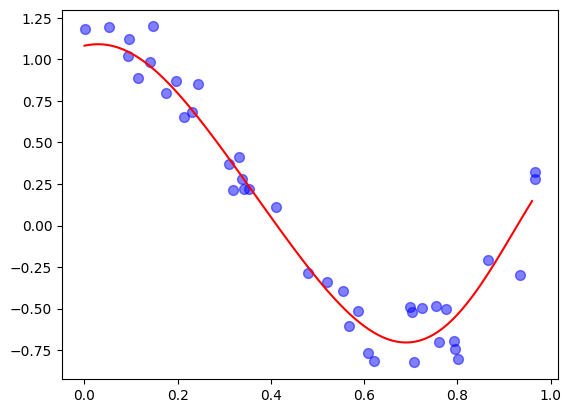

In [25]:
regressor3 = svm.SVR(kernel = 'rbf')
regressor3.fit(X2R, y2R)

xv = np.arange(min(X2R), max(X2R), 0.01).reshape(-1, 1)
plt.scatter(X2R, y2R, color = 'blue', s=50, alpha=.5)
plt.plot(xv, regressor3.predict(xv), color = 'red')

plt.show()